In [1]:
import tensorflow as tf
import numpy as np
import math
from censai import PhysicalModelv2, RIMSharedUnetv2
from censai.models import SharedUnetModelv2, RayTracer
from censai.utils import nullwriter, rim_residual_plot as residual_plot, plot_to_image
from censai.data.lenses_tng_v3 import decode_train, decode_physical_model_info
from censai.definitions import DTYPE
import os, glob, time, json
from datetime import datetime


RIM_HPARAMS = [
    "adam",
    "steps",
    "kappalog",
    "kappa_normalize",
    "kappa_init",
    "source_init"
]
UNET_MODEL_HPARAMS = [
    "filters",
    "filter_scaling",
    "kernel_size",
    "layers",
    "block_conv_layers",
    "strides",
    "bottleneck_kernel_size",
    "resampling_kernel_size",
    "input_kernel_size",
    "gru_kernel_size",
    "upsampling_interpolation",
    "batch_norm",
    "dropout_rate",
    "kernel_l2_amp",
    "bias_l2_amp",
    "kernel_l1_amp",
    "bias_l1_amp",
    "activation",
    "alpha",
    "initializer",
    "gru_architecture"
]


In [2]:
def main(args):
    if args.seed is not None:
        tf.random.set_seed(args.seed)
        np.random.seed(args.seed)
    if args.json_override is not None:
        if isinstance(args.json_override, list):
            files = args.json_override
        else:
            files = [args.json_override,]
        for file in files:
            with open(file, "r") as f:
                json_override = json.load(f)
            args_dict = vars(args)
            args_dict.update(json_override)

    files = []
    for dataset in args.datasets:
        files.extend(glob.glob(os.path.join(dataset, "*.tfrecords")))
    np.random.shuffle(files)

    if args.val_datasets is not None:
        """    
        In this conditional, we assume total items might be a subset of the dataset size.
        Thus we want to reshuffle at each epoch to get a different realisation of the dataset. 
        In case total_items == true dataset size, this means we only change ordering of items each epochs.
        
        Also, validation is not a split of the training data, but a saved dataset on disk. 
        """
        files = tf.data.Dataset.from_tensor_slices(files)
        dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type=args.compression_type).shuffle(len(files), reshuffle_each_iteration=True),
                                   block_length=args.block_length, num_parallel_calls=tf.data.AUTOTUNE)
        # Read off global parameters from first example in dataset
        for physical_params in dataset.map(decode_physical_model_info):
            break
        # preprocessing
        dataset = dataset.map(decode_train)
        if args.cache_file is not None:
            dataset = dataset.cache(args.cache_file)
        train_dataset = dataset.shuffle(buffer_size=args.buffer_size, reshuffle_each_iteration=True).take(args.total_items).batch(args.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

        val_files = []
        for dataset in args.val_datasets:
            val_files.extend(glob.glob(os.path.join(dataset, "*.tfrecords")))
        val_files = tf.data.Dataset.from_tensor_slices(val_files)
        val_dataset = val_files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type=args.compression_type), block_length=args.block_length, num_parallel_calls=tf.data.AUTOTUNE)
        val_dataset = val_dataset.map(decode_train).shuffle(buffer_size=args.buffer_size, reshuffle_each_iteration=True).\
            take(math.ceil((1 - args.train_split) * args.total_items)).\
            batch(args.batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    else:
        """
        Here, we split the dataset, so we assume total_items is the true dataset size. Any extra items will be discarded. 
        This is to make sure validation set is never seen by the model, so shuffling occurs after the split.
        """
        files = tf.data.Dataset.from_tensor_slices(files)
        dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type=args.compression_type),
                                   block_length=args.block_length, num_parallel_calls=tf.data.AUTOTUNE)
        # Read off global parameters from first example in dataset
        for physical_params in dataset.map(decode_physical_model_info):
            break
        # preprocessing
        dataset = dataset.map(decode_train)
        if args.cache_file is not None:
            dataset = dataset.cache(args.cache_file)
        train_dataset = dataset.take(math.floor(args.train_split * args.total_items)).shuffle(buffer_size=args.buffer_size, reshuffle_each_iteration=True).batch(args.batch_size).prefetch(tf.data.experimental.AUTOTUNE)
        val_dataset = dataset.skip(math.floor(args.train_split * args.total_items)).take(math.ceil((1 - args.train_split) * args.total_items)).batch(args.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

#     train_dataset = STRATEGY.experimental_distribute_dataset(train_dataset)
#     val_dataset = STRATEGY.experimental_distribute_dataset(val_dataset)
#     with STRATEGY.scope():  # Replicate ops accross gpus
    if args.raytracer is not None:
        with open(os.path.join(args.raytracer, "ray_tracer_hparams.json"), "r") as f:
            raytracer_hparams = json.load(f)
        raytracer = RayTracer(**raytracer_hparams)
        # load last checkpoint in the checkpoint directory
        checkpoint = tf.train.Checkpoint(net=raytracer)
        manager = tf.train.CheckpointManager(checkpoint, directory=args.raytracer, max_to_keep=3)
        checkpoint.restore(manager.latest_checkpoint).expect_partial()
    else:
        raytracer = None
    phys = PhysicalModelv2(
        pixels=physical_params["pixels"].numpy(),
        kappa_pixels=physical_params["kappa pixels"].numpy(),
        src_pixels=physical_params["src pixels"].numpy(),
        image_fov=physical_params["image fov"].numpy(),
        kappa_fov=physical_params["kappa fov"].numpy(),
        src_fov=physical_params["source fov"].numpy(),
        method=args.forward_method,
        raytracer=raytracer,
    )

    unet = SharedUnetModelv2(
        filters=args.filters,
        filter_scaling=args.filter_scaling,
        kernel_size=args.kernel_size,
        layers=args.layers,
        block_conv_layers=args.block_conv_layers,
        strides=args.strides,
        bottleneck_kernel_size=args.bottleneck_kernel_size,
        resampling_kernel_size=args.resampling_kernel_size,
        input_kernel_size=args.input_kernel_size,
        gru_kernel_size=args.gru_kernel_size,
        upsampling_interpolation=args.upsampling_interpolation,
        kernel_l2_amp=args.kernel_l2_amp,
        bias_l2_amp=args.bias_l2_amp,
        kernel_l1_amp=args.kernel_l1_amp,
        bias_l1_amp=args.bias_l1_amp,
        activation=args.activation,
        alpha=args.alpha,
        initializer=args.initializer,
        batch_norm=args.batch_norm,
        dropout_rate=args.dropout_rate
    )
    rim = RIMSharedUnetv2(
        physical_model=phys,
        unet=unet,
        steps=args.steps,
        adam=args.adam,
        kappalog=args.kappalog,
        source_link=args.source_link,
        kappa_normalize=args.kappa_normalize,
        kappa_init=args.kappa_init,
        source_init=args.source_init
    )
    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=args.initial_learning_rate,
        decay_rate=args.decay_rate,
        decay_steps=args.decay_steps,
        staircase=args.staircase
    )
    optim = tf.keras.optimizers.deserialize(
        {
            "class_name": args.optimizer,
            'config': {"learning_rate": learning_rate_schedule}
        }
    )
    # weights for time steps in the loss function
    if args.time_weights == "uniform":
        wt = tf.ones(shape=(args.steps), dtype=DTYPE) / args.steps
    elif args.time_weights == "linear":
        wt = 2 * (tf.range(args.steps, dtype=DTYPE) + 1) / args.steps / (args.steps + 1)
    elif args.time_weights == "quadratic":
        wt = 6 * (tf.range(args.steps, dtype=DTYPE) + 1)**2 / args.steps / (args.steps + 1) / (2 * args.steps + 1)
    else:
        raise ValueError("time_weights must be in ['uniform', 'linear', 'quadratic']")
    wt = wt[..., tf.newaxis]  # [steps, batch]

    if args.kappa_residual_weights == "uniform":
        wk = tf.keras.layers.Lambda(lambda k: tf.ones_like(k, dtype=DTYPE) / tf.cast(tf.math.reduce_prod(k.shape[1:]), DTYPE))
    elif args.kappa_residual_weights == "linear":
        wk = tf.keras.layers.Lambda(lambda k: k / tf.reduce_sum(k, axis=(1, 2, 3), keepdims=True))
    elif args.kappa_residual_weights== "sqrt":
        wk = tf.keras.layers.Lambda(lambda k: tf.sqrt(k) / tf.reduce_sum(tf.sqrt(k), axis=(1, 2, 3), keepdims=True))
    elif args.kappa_residual_weights == "quadratic":
        wk = tf.keras.layers.Lambda(lambda k: tf.square(k) / tf.reduce_sum(tf.square(k), axis=(1, 2, 3), keepdims=True))
    else:
        raise ValueError("kappa_residual_weights must be in ['uniform', 'linear', 'quadratic', 'sqrt']")

    # ==== Take care of where to write logs and stuff =================================================================
    if args.model_id.lower() != "none":
        if args.logname is not None:
            logname = args.model_id + "_" + args.logname
            model_id = args.model_id
        else:
            logname = args.model_id + "_" + datetime.now().strftime("%y%m%d%H%M%S")
            model_id = args.model_id
    elif args.logname is not None:
        logname = args.logname
        model_id = logname
    else:
        logname = args.logname_prefixe + "_" + datetime.now().strftime("%y%m%d%H%M%S")
        model_id = logname
    if args.logdir.lower() != "none":
        logdir = os.path.join(args.logdir, logname)
        if not os.path.isdir(logdir):
            os.mkdir(logdir)
        writer = tf.summary.create_file_writer(logdir)
    else:
        writer = nullwriter()
    # ===== Make sure directory and checkpoint manager are created to save model ===================================
    if args.model_dir.lower() != "none":
        checkpoints_dir = os.path.join(args.model_dir, logname)
        old_checkpoints_dir = os.path.join(args.model_dir, model_id)  # in case they differ we load model from a different directory
        if not os.path.isdir(checkpoints_dir):
            os.mkdir(checkpoints_dir)
            with open(os.path.join(checkpoints_dir, "script_params.json"), "w") as f:
                json.dump(vars(args), f, indent=4)
            with open(os.path.join(checkpoints_dir, "unet_hparams.json"), "w") as f:
                hparams_dict = {key: vars(args)[key] for key in UNET_MODEL_HPARAMS}
                json.dump(hparams_dict, f, indent=4)
            with open(os.path.join(checkpoints_dir, "rim_hparams.json"), "w") as f:
                hparams_dict = {key: vars(args)[key] for key in RIM_HPARAMS}
                json.dump(hparams_dict, f, indent=4)
        ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optim, net=rim.unet)
        checkpoint_manager = tf.train.CheckpointManager(ckpt, old_checkpoints_dir, max_to_keep=args.max_to_keep)
        save_checkpoint = True
        # ======= Load model if model_id is provided ===============================================================
        if args.model_id.lower() != "none":
            checkpoint_manager.checkpoint.restore(checkpoint_manager.latest_checkpoint)
        if old_checkpoints_dir != checkpoints_dir:  # save progress in another directory.
            if args.reset_optimizer_states:
                optim = tf.keras.optimizers.deserialize(
                    {
                        "class_name": args.optimizer,
                        'config': {"learning_rate": learning_rate_schedule}
                    }
                )
                ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optim, net=rim.unet)
            checkpoint_manager = tf.train.CheckpointManager(ckpt, checkpoints_dir, max_to_keep=args.max_to_keep)

    else:
        save_checkpoint = False
    # =================================================================================================================

    def train_step(X, source, kappa, noise_rms, psf):
        with tf.GradientTape() as tape:
            tape.watch(rim.unet.trainable_variables)
            if args.unroll_time_steps:
                source_series, kappa_series, chi_squared = rim.call_function(X, noise_rms, psf)
            else:
                source_series, kappa_series, chi_squared = rim.call(X, noise_rms, psf, outer_tape=tape)
            # mean over image residuals
            source_cost = tf.reduce_mean(tf.square(source_series - rim.source_inverse_link(source)), axis=(2, 3, 4))
            kappa_cost = tf.reduce_sum(wk * tf.square(kappa_series - rim.kappa_inverse_link(kappa)), axis=(2, 3, 4))
            # weighted mean over time steps
            source_cost = tf.reduce_sum(wt * source_cost, axis=0)
            kappa_cost = tf.reduce_sum(wt * kappa_cost, axis=0)
            # final cost is mean over global batch size
            cost = tf.reduce_sum(kappa_cost + source_cost) / args.batch_size
        gradient = tape.gradient(cost, rim.unet.trainable_variables)
        if args.clipping:
            gradient = [tf.clip_by_norm(grad, 10.) for grad in gradient]
        optim.apply_gradients(zip(gradient, rim.unet.trainable_variables))
        # Update metrics with "converged" score
        chi_squared = tf.reduce_sum(chi_squared[-1]) / args.batch_size
        source_cost = tf.reduce_sum(source_cost1[-1]) / args.batch_size
        kappa_cost = tf.reduce_sum(kappa_cost1[-1]) / args.batch_size
        return cost, chi_squared, source_cost, kappa_cost

#     @tf.function
#     def distributed_train_step(X, source, kappa, noise_rms, psf):
#         per_replica_losses, per_replica_chi_squared, per_replica_source_cost, per_replica_kappa_cost = STRATEGY.run(train_step, args=(X, source, kappa, noise_rms, psf))
#         # Replica losses are aggregated by summing them
#         global_loss = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)
#         global_chi_squared = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_chi_squared, axis=None)
#         global_source_cost = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_source_cost, axis=None)
#         global_kappa_cost = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_kappa_cost, axis=None)
#         return global_loss, global_chi_squared, global_source_cost, global_kappa_cost

#     def test_step(X, source, kappa, noise_rms, psf):
#         source_series, kappa_series, chi_squared = rim.call(X, noise_rms, psf)
#         # mean over image residuals
#         source_cost1 = tf.reduce_mean(tf.square(source_series - rim.source_inverse_link(source)), axis=(2, 3, 4))
#         kappa_cost1 = tf.reduce_mean(tf.square(kappa_series - rim.kappa_inverse_link(kappa)), axis=(2, 3, 4))
#         # weighted mean over time steps
#         source_cost = tf.reduce_sum(wt * source_cost1, axis=0)
#         kappa_cost = tf.reduce_sum(wt * kappa_cost1, axis=0)
#         # final cost is mean over global batch size
#         cost = tf.reduce_sum(kappa_cost + source_cost) / args.batch_size
#         chi_squared = tf.reduce_sum(chi_squared[-1]) / args.batch_size
#         source_cost = tf.reduce_sum(source_cost1[-1]) / args.batch_size
#         kappa_cost = tf.reduce_sum(kappa_cost1[-1]) / args.batch_size
#         return cost, chi_squared, source_cost, kappa_cost

#     @tf.function
#     def distributed_test_step(X, source, kappa, noise_rms, psf):
#         per_replica_losses, per_replica_chi_squared, per_replica_source_cost, per_replica_kappa_cost = STRATEGY.run(test_step, args=(X, source, kappa, noise_rms, psf))
#         # Replica losses are aggregated by summing them
#         global_loss = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)
#         global_chi_squared = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_chi_squared, axis=None)
#         global_source_cost = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_source_cost, axis=None)
#         global_kappa_cost = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_kappa_cost, axis=None)
#         return global_loss, global_chi_squared, global_source_cost, global_kappa_cost

    # ====== Training loop ============================================================================================
    epoch_loss = tf.metrics.Mean()
    time_per_step = tf.metrics.Mean()
    val_loss = tf.metrics.Mean()
    epoch_chi_squared = tf.metrics.Mean()
    epoch_source_loss = tf.metrics.Mean()
    epoch_kappa_loss = tf.metrics.Mean()
    val_chi_squared = tf.metrics.Mean()
    val_source_loss = tf.metrics.Mean()
    val_kappa_loss = tf.metrics.Mean()
    history = {  # recorded at the end of an epoch only
        "train_cost": [],
        "train_chi_squared": [],
        "train_source_cost": [],
        "train_kappa_cost": [],
        "val_cost": [],
        "val_chi_squared": [],
        "val_source_cost": [],
        "val_kappa_cost": [],
        "learning_rate": [],
        "time_per_step": [],
        "step": [],
        "wall_time": []
    }
    best_loss = np.inf
    patience = args.patience
    step = 0
    global_start = time.time()
    estimated_time_for_epoch = 0
    out_of_time = False
    lastest_checkpoint = 1
    for epoch in range(args.epochs):
        if (time.time() - global_start) > args.max_time*3600 - estimated_time_for_epoch:
            break
#         epoch_start = time.time()
#         epoch_loss.reset_states()
#         epoch_chi_squared.reset_states()
#         epoch_source_loss.reset_states()
#         epoch_kappa_loss.reset_states()
#         time_per_step.reset_states()
        with writer.as_default():
            for batch, (X, source, kappa, noise_rms, psf) in enumerate(train_dataset):
                start = time.time()
                cost, chi_squared, source_cost, kappa_cost = train_step(X, source, kappa, noise_rms, psf)
        # ========== Summary and logs ==================================================================================
                _time = time.time() - start
                time_per_step.update_state([_time])
                epoch_loss.update_state([cost])
                epoch_chi_squared.update_state([chi_squared])
                epoch_source_loss.update_state([source_cost])
                epoch_kappa_loss.update_state([kappa_cost])
                step += 1
#             # last batch we make a summary of residuals
#             if args.n_residuals > 0:
#                 source_pred, kappa_pred, chi_squared = rim.predict(X, noise_rms, psf)
#                 lens_pred = phys.forward(source_pred[-1], kappa_pred[-1], psf)
#             for res_idx in range(min(args.n_residuals, args.batch_size)):
#                 try:
#                     tf.summary.image(f"Residuals {res_idx}",
#                                      plot_to_image(
#                                          residual_plot(
#                                              X[res_idx],
#                                              source[res_idx],
#                                              kappa[res_idx],
#                                              lens_pred[res_idx],
#                                              source_pred[-1][res_idx],
#                                              kappa_pred[-1][res_idx],
#                                              chi_squared[-1][res_idx]
#                                          )), step=step)
#                 except ValueError:
#                     continue

#             # ========== Validation set ===================
#             val_loss.reset_states()
#             val_chi_squared.reset_states()
#             val_source_loss.reset_states()
#             val_kappa_loss.reset_states()
#             for X, source, kappa, noise_rms, psf in val_dataset:
#                 cost, chi_squared, source_cost, kappa_cost = distributed_test_step(X, source, kappa, noise_rms, psf)
#                 val_loss.update_state([cost])
#                 val_chi_squared.update_state([chi_squared])
#                 val_source_loss.update_state([source_cost])
#                 val_kappa_loss.update_state([kappa_cost])

#             if args.n_residuals > 0 and math.ceil((1 - args.train_split) * args.total_items) > 0:  # validation set not empty set not empty
#                 source_pred, kappa_pred, chi_squared = rim.predict(X, noise_rms, psf)
#                 lens_pred = phys.forward(source_pred[-1], kappa_pred[-1], psf)
#             for res_idx in range(min(args.n_residuals, args.batch_size, math.ceil((1 - args.train_split) * args.total_items))):
#                 try:
#                     tf.summary.image(f"Val Residuals {res_idx}",
#                                      plot_to_image(
#                                          residual_plot(
#                                              X[res_idx],  # rescale intensity like it is done in the likelihood
#                                              source[res_idx],
#                                              kappa[res_idx],
#                                              lens_pred[res_idx],
#                                              source_pred[-1][res_idx],
#                                              kappa_pred[-1][res_idx],
#                                              chi_squared[-1][res_idx]
#                                          )), step=step)
#                 except ValueError:
#                     continue
#             val_cost = val_loss.result().numpy()
            train_cost = epoch_loss.result().numpy()
#             val_chi_sq = val_chi_squared.result().numpy()
            train_chi_sq = epoch_chi_squared.result().numpy()
#             val_kappa_cost = val_kappa_loss.result().numpy()
            train_kappa_cost = epoch_kappa_loss.result().numpy()
#             val_source_cost = val_source_loss.result().numpy()
            train_source_cost = epoch_source_loss.result().numpy()
            tf.summary.scalar("Time per step", time_per_step.result(), step=step)
            tf.summary.scalar("Chi Squared", train_chi_sq, step=step)
            tf.summary.scalar("Kappa cost", train_kappa_cost, step=step)
#             tf.summary.scalar("Val Kappa cost", val_kappa_cost, step=step)
            tf.summary.scalar("Source cost", train_source_cost, step=step)
#             tf.summary.scalar("Val Source cost", val_source_cost, step=step)
            tf.summary.scalar("MSE", train_cost, step=step)
#             tf.summary.scalar("Val MSE", val_cost, step=step)
            tf.summary.scalar("Learning Rate", optim.lr(step), step=step)
#             tf.summary.scalar("Val Chi Squared", val_chi_sq, step=step)
        print(f"epoch {epoch} | train loss {train_cost:.3e} "
              f"| lr {optim.lr(step).numpy():.2e} | time per step {time_per_step.result().numpy():.2e} s"
              f"| kappa cost {train_kappa_cost:.2e} | source cost {train_source_cost:.2e} | chi sq {train_chi_sq:.2e}")
        history["train_cost"].append(train_cost)
#         history["val_cost"].append(val_cost)
        history["learning_rate"].append(optim.lr(step).numpy())
        history["train_chi_squared"].append(train_chi_sq)
#         history["val_chi_squared"].append(val_chi_sq)
        history["time_per_step"].append(time_per_step.result().numpy())
        history["train_kappa_cost"].append(train_kappa_cost)
        history["train_source_cost"].append(train_source_cost)
#         history["val_kappa_cost"].append(val_kappa_cost)
#         history["val_source_cost"].append(val_source_cost)
        history["step"].append(step)
        history["wall_time"].append(time.time() - global_start)

        cost = train_cost
        if np.isnan(cost):
            print("Training broke the Universe")
            break
        if cost < (1 - args.tolerance) * best_loss:
            best_loss = cost
            patience = args.patience
        else:
            patience -= 1
        if (time.time() - global_start) > args.max_time * 3600:
            out_of_time = True
        if save_checkpoint:
            checkpoint_manager.checkpoint.step.assign_add(1) # a bit of a hack
            if epoch % args.checkpoints == 0 or patience == 0 or epoch == args.epochs - 1 or out_of_time:
                with open(os.path.join(checkpoints_dir, "score_sheet.txt"), mode="a") as f:
                    np.savetxt(f, np.array([[lastest_checkpoint, cost]]))
                lastest_checkpoint += 1
                checkpoint_manager.save()
                print("Saved checkpoint for step {}: {}".format(int(checkpoint_manager.checkpoint.step), checkpoint_manager.latest_checkpoint))
        if patience == 0:
            print("Reached patience")
            break
        if out_of_time:
            break
        if epoch > 0:  # First epoch is always very slow and not a good estimate of an epoch time.
            estimated_time_for_epoch = time.time() - epoch_start
        if optim.lr(step).numpy() < 1e-8:
            print("Reached learning rate limit")
            break
    print(f"Finished training after {(time.time() - global_start)/3600:.3f} hours.")
    return rim, phys, train_dataset, val_dataset


In [3]:
from argparse import ArgumentParser
parser = ArgumentParser()
parser.add_argument("--model_id",               default="None",                 help="Start from this model id checkpoint. None means start from scratch")
parser.add_argument("--datasets",               required=True,  nargs="+",      help="Path to directories that contains tfrecords of dataset. Can be multiple inputs (space separated)")
parser.add_argument("--val_datasets",           default=None,  nargs="+",       help="Validation dataset path")
parser.add_argument("--compression_type",       default=None,                   help="Compression type used to write data. Default assumes no compression.")

# RIM hyperparameters
parser.add_argument("--steps",              default=16,     type=int,       help="Number of time steps of RIM")
parser.add_argument("--adam",               action="store_true",            help="ADAM update for the log-likelihood gradient.")
parser.add_argument("--kappalog",           action="store_true")
parser.add_argument("--kappa_normalize",    action="store_true")
parser.add_argument("--source_link",        default="identity",             help="One of 'exp', 'source', 'relu' or 'identity' (default).")
parser.add_argument("--kappa_init",         default=1e-1,   type=float,     help="Initial value of kappa for RIM")
parser.add_argument("--source_init",        default=1e-3,   type=float,     help="Initial value of source for RIM")
parser.add_argument("--kappa_residual_weights",     default="uniform",      help="Options are ['uniform', 'linear', 'quadratic', 'sqrt']")

# Shared Unet params
parser.add_argument("--filters",                                    default=32,     type=int)
parser.add_argument("--filter_scaling",                             default=1,      type=float)
parser.add_argument("--kernel_size",                                default=3,      type=int)
parser.add_argument("--layers",                                     default=2,      type=int)
parser.add_argument("--block_conv_layers",                          default=2,      type=int)
parser.add_argument("--strides",                                    default=2,      type=int)
parser.add_argument("--bottleneck_kernel_size",                     default=None,   type=int)
parser.add_argument("--resampling_kernel_size",                     default=None,   type=int)
parser.add_argument("--input_kernel_size",                          default=11,     type=int)
parser.add_argument("--gru_kernel_size",                            default=None,   type=int)
parser.add_argument("--upsampling_interpolation",                   action="store_true")
parser.add_argument("--batch_norm",                                 action="store_true")
parser.add_argument("--dropout_rate",                               default=None,   type=float)
parser.add_argument("--kernel_l2_amp",                              default=0,      type=float)
parser.add_argument("--bias_l2_amp",                                default=0,      type=float)
parser.add_argument("--kernel_l1_amp",                              default=0,      type=float)
parser.add_argument("--bias_l1_amp",                                default=0,      type=float)
parser.add_argument("--activation",                                 default="leaky_relu")
parser.add_argument("--alpha",                                      default=0.3,    type=float)
parser.add_argument("--initializer",                                default="glorot_normal")
parser.add_argument("--gru_architecture",                           default="concat",   help="'concat': architecture of Laurence. 'plus': original RNN architecture")

# Physical model hyperparameter
parser.add_argument("--forward_method",         default="conv2d",               help="One of ['conv2d', 'fft', 'unet']. If the option 'unet' is chosen, the parameter "
                                                                                     "'--raytracer' must be provided and point to model checkpoint directory.")
parser.add_argument("--raytracer",              default=None,                   help="Path to raytracer checkpoint dir if method 'unet' is used.")

# Training set params
parser.add_argument("-b", "--batch_size",       default=1,      type=int,       help="Number of images in a batch. ")
parser.add_argument("--train_split",            default=0.8,    type=float,     help="Fraction of the training set.")
parser.add_argument("--total_items",            required=True,  type=int,       help="Total images in an epoch.")
# ... for tfrecord dataset
parser.add_argument("--cache_file",             default=None,                   help="Path to cache file, useful when training on server. Use ${SLURM_TMPDIR}/cache")
parser.add_argument("--block_length",           default=1,      type=int,       help="Number of example to read from each files at a given moment.")
parser.add_argument("--buffer_size",            default=1000,   type=int,       help="Buffer size for shuffling at each epoch.")

# Optimization params
parser.add_argument("-e", "--epochs",           default=10,     type=int,       help="Number of epochs for training.")
parser.add_argument("--optimizer",              default="Adam",                 help="Class name of the optimizer (e.g. 'Adam' or 'Adamax')")
parser.add_argument("--initial_learning_rate",  default=1e-3,   type=float,     help="Initial learning rate.")
parser.add_argument("--decay_rate",             default=1.,     type=float,     help="Exponential decay rate of learning rate (1=no decay).")
parser.add_argument("--decay_steps",            default=1000,   type=int,       help="Decay steps of exponential decay of the learning rate.")
parser.add_argument("--staircase",              action="store_true",            help="Learning rate schedule only change after decay steps if enabled.")
parser.add_argument("--clipping",               action="store_true",            help="Clip backprop gradients between -10 and 10.")
parser.add_argument("--patience",               default=np.inf, type=int,       help="Number of step at which training is stopped if no improvement is recorder.")
parser.add_argument("--tolerance",              default=0,      type=float,     help="Current score <= (1 - tolerance) * best score => reset patience, else reduce patience.")
parser.add_argument("--track_train",            action="store_true",            help="Track training metric instead of validation metric, in case we want to overfit")
parser.add_argument("--max_time",               default=np.inf, type=float,     help="Time allowed for the training, in hours.")
parser.add_argument("--time_weights",           default="uniform",              help="uniform: w_t=1 for all t, linear: w_t~t, quadratic: w_t~t^2")
parser.add_argument("--unroll_time_steps",      action="store_true",            help="Unroll time steps of RIM in GPU usinf tf.function")
parser.add_argument("--reset_optimizer_states",  action="store_true",           help="When training from pre-trained weights, reset states of optimizer.")

# logs
parser.add_argument("--logdir",                  default="None",                help="Path of logs directory. Default if None, no logs recorded.")
parser.add_argument("--logname",                 default=None,                  help="Overwrite name of the log with this argument")
parser.add_argument("--logname_prefixe",         default="RIMSUv3",             help="If name of the log is not provided, this prefix is prepended to the date")
parser.add_argument("--model_dir",               default="None",                help="Path to the directory where to save models checkpoints.")
parser.add_argument("--checkpoints",             default=10,    type=int,       help="Save a checkpoint of the models each {%} iteration.")
parser.add_argument("--max_to_keep",             default=3,     type=int,       help="Max model checkpoint to keep.")
parser.add_argument("--n_residuals",             default=1,     type=int,       help="Number of residual plots to save. Add overhead at the end of an epoch only.")

# Reproducibility params
parser.add_argument("--seed",                   default=None,   type=int,       help="Random seed for numpy and tensorflow.")
parser.add_argument("--json_override",          default=None,   nargs="+",     help="A json filepath that will override every command line parameters. Useful for reproducibility")


_StoreAction(option_strings=['--json_override'], dest='json_override', nargs='+', const=None, default=None, type=None, choices=None, help='A json filepath that will override every command line parameters. Useful for reproducibility', metavar=None)

In [4]:
import sys
sys.argv = ['']
# model_id = "RIMSU512_hk128_TNG2nsO_008_F16_IK7_NLrelu_82_B10_lr0.0005_dr0.5_ds10000_211005114812"
args = parser.parse_args(
  f"--datasets {os.getenv('CENSAI_PATH')}/data/lenses128hst_TNG_rau_200k_control_validated_train "\
#   f"--model_id={model_id} "\
  f"--forward_method=fft "\
#   f"--forward_method=unet "\
#   f"--raytracer={os.getenv('CENSAI_PATH')}/models/RT128_512_grid4_010_FS2.0_K3_F16_42_lr0.0001_ds50000_211006132142 "\
  f"--compression_type=GZIP "\
  f"--optimizer=ADAMAX "\
  f"--epochs=5000 "\
  f"--max_time=1 "\
  f"--initial_learning_rate=1e-3 "\
  f"--decay_rate=0.5 "\
  f"--decay_steps=1000 "\
  f"--staircase "\
  f"--clipping "\
  f"--patience=200 "\
  f"--tolerance=0.01 "\
  f"--batch_size=1 "\
  f"--train_split=1 "\
  f"--total_items=1 "\
  f"--block_length=1 "\
  f"--buffer_size=100 "\
  f"--steps=5 "\
  f"--time_weights=uniform "\
  f"--adam "\
  f"--kappalog "\
  f"--source_link=lrelu4p "\
  f"--filters=8 "\
  f"--filter_scaling=2 "\
  f"--kernel_size=3 "\
  f"--input_kernel_size=11 "\
  f"--layers=4 "\
  f"--block_conv_layers=1 "\
  "--kappa_init=1e-1 "\
  "--source_init=1 "\
  f"--resampling_kernel_size=3 "\
  "--kappa_residual_weights=uniform "\
#   f"--gru_kernel_size=3 "\
  f"--batch_norm "\
#   f"--dropout=0.1 "\
#   f"--upsampling_interpolation "\
#   f"--kernel_l2_amp=1e-4 "\
#   f"--bias_l2_amp=1e-4 "\
#   f"--kernel_l1_amp=1e-3 "\
#   f"--bias_l1_amp=1e-3 "\
  f"--activation=leaky_relu "\
#   f"--alpha=0.3 "\
  f"--cache_file={os.getenv('SLURM_TMPDIR')}/cache "\
  f"--logdir={os.getenv('HOME')}/scratch/Censai/logs "\
  f"--logname_prefixe=RIMSU512_k128_hTNG_interactive "\
  f"--track_train "\
  f"--model_dir={os.getenv('HOME')}/scratch/Censai/models "\
  f"--checkpoints=5 "\
  f"--max_to_keep=3 "\
  f"--seed=42 "\
  f"--n_residuals=0 "\
   "--track_train".split(" ")
#   f"--json_override {os.getenv('CENSAI_PATH')}/models/{model_id}/unet_hparams.json {os.getenv('CENSAI_PATH')}/models/{model_id}/rim_hparams.json".split()
)
if args.json_override is not None:
    if isinstance(args.json_override, list):
        files = args.json_override
    else:
        files = [args.json_override,]
    for file in files:
        with open(file, "r") as f:
            json_override = json.load(f)
        args_dict = vars(args)
        args_dict.update(json_override)
cache_files = glob.glob(f"{os.getenv('SLURM_TMPDIR')}/cache*")
for cache in cache_files:
    os.remove(cache)
rim, phys, train_dataset, val_dataset = main(args)

ValueError: Incompatible shape for value ((1,)), expected (())

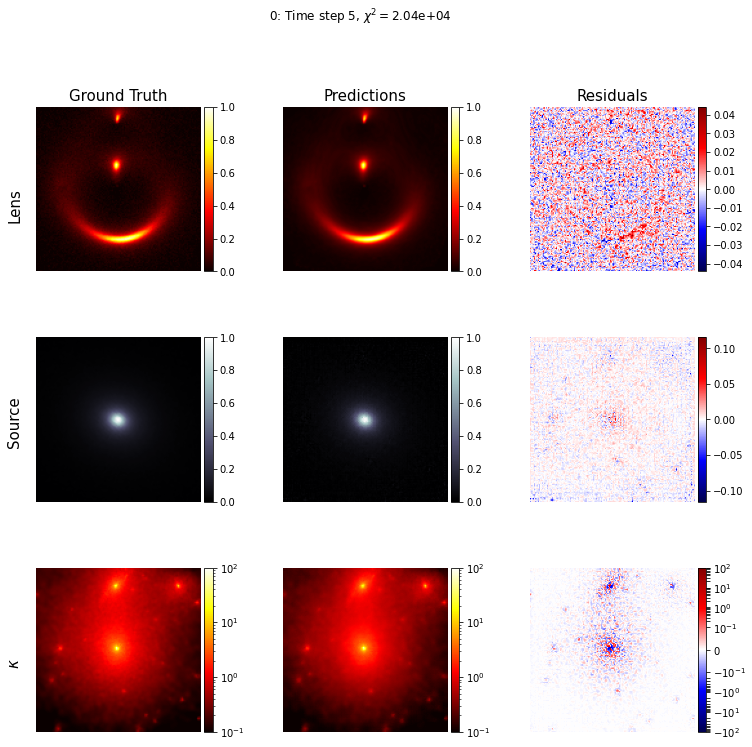

In [42]:
# phys.forward_method = "fft"
for batch, distributed_inputs in enumerate(train_dataset):
    for res_idx in range(args.batch_size):
        lens_true = distributed_inputs[0][res_idx]
#         lens_true /= tf.reduce_max(lens_true, axis=(0, 1, 2), keepdims=True)
        source_true = distributed_inputs[1][res_idx]
        kappa_true = distributed_inputs[2][res_idx]
        source_pred, kappa_pred, chi_squared = rim.predict(lens_true[None])
        source_pred = tf.nn.relu(source_pred[-1])
        source_pred /= tf.reduce_max(source_pred, axis=(1, 2, 3))
        lens_true = phys.noisy_forward(source_true[None, ...], kappa_true[None, ...], 0.01)[0]
        lens_pred = phys.forward(source_pred, kappa_pred[-1])[0]
#         lens_pred = tf.nn.relu(lens_pred)
        lam = phys.masked_lagrange_multiplier(lens_true[None, ...], lens_pred[None, ...])[0]
        fig = residual_plot(lens_true, source_true, kappa_true, lens_pred, source_pred[0, ...], kappa_pred[-1][0, ...], chi_squared[-1][0])
        fig.suptitle(fr"{batch}: Time step {args.steps}, $\chi^2 = ${chi_squared[-1][0]:.2e}")
#     break